In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
# Add libraries and functions
library(gsignal)
library(eyeris)
library(dplyr)
source("../../src/riskyneuroarousal/preprocessing/remove_gaze_regressor.R")
source("../../src/riskyneuroarousal/preprocessing/load_data.R")
source("../../src/riskyneuroarousal/preprocessing/add_nan_descriptors.R")
source("../../src/riskyneuroarousal/preprocessing/replace_out_of_bounds.R")


Attaching package: ‘gsignal’

The following objects are masked from ‘package:stats’:

    filter, gaussian, poly


Attaching package: ‘eyeris’

The following object is masked from ‘package:gsignal’:

    detrend


Attaching package: ‘dplyr’

The following object is masked from ‘package:gsignal’:

    filter

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


In [4]:
%%R
file <- "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/sub-003_run-1.asc"
valid_subs <- c("sub-003")

# Load the data
loaded_data <- load_data(file, valid_subs)

# Make the data items available in the global environment
data <- loaded_data$data
subject_id <- loaded_data$subject_id
run_id <- loaded_data$run_id
subject_num <- loaded_data$subject_num
run_num <- loaded_data$run_num

[1] "Processing sub-003 run-1"


In [5]:
%%R
# (5) Remove the gaze regressor
data <- remove_gaze_regressor(data)
mean_pupil_size <- mean(data$timeseries$pupil_raw, na.rm = TRUE)
# (3) Replace out of bounds values with NA
data <- replace_out_of_bounds(data)

# (4) Add indicator variables for blink and out of bounds
data <- add_nan_descriptors(data)

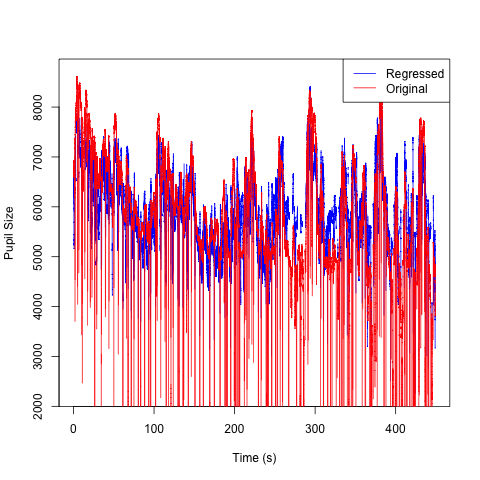

In [7]:
%%R
# Plot to compare how the data looks
time <- data$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000

# plot pupil_raw and pupil_raw_orig
plot(time, data$timeseries$pupil_raw, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size")
lines(time, data$timeseries$pupil_raw_orig, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)


In [58]:
%%R
eye_preproc <- (eyeris::deblink(data, extend = 100) |> 
                eyeris::detransient(n = 16) |> 
                eyeris::interpolate() |> 
                eyeris::lpfilt(wp = 0.025, ws = 0.05, rp = 1, rs = 35) |>
                eyeris::zscore())

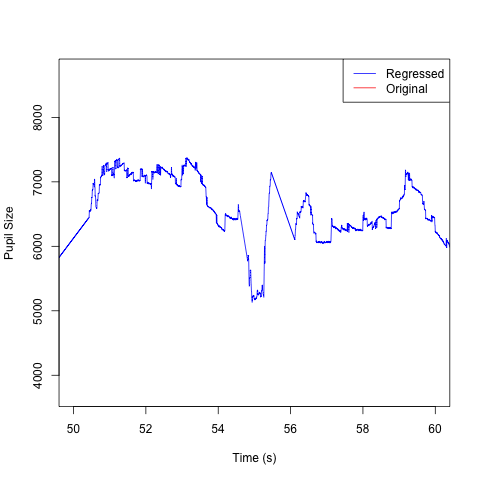

In [55]:
%%R
time <- eye_preproc$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000
# plot pupil_raw and pupil_raw_orig
plot(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size", xlim=c(50, 60))
# lines(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)

In [20]:
%%R
# Bandpass filter the data
fs <- eye_preproc$info$sample.rate
fpass <- c(0.02, 4)
wpass <- fpass / (fs / 2)
but <- gsignal::butter(2, wpass, "pass")
eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt <- gsignal::filtfilt(but, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate) + mean_pupil_size

In [59]:
%%R
# Define target sampling rate
target_hz <- 50
original_hz <- eye_preproc$info$sample.rate
resample_factor <- original_hz / target_hz

eye_preproc$timeseries <- eye_preproc$timeseries %>%
mutate(bin = ceiling(row_number() / resample_factor)) %>%
group_by(bin) %>%
summarise(
# Apply mean to specific columns
eye_x = mean(eye_x, na.rm = TRUE),
eye_y = mean(eye_y, na.rm = TRUE),


# Apply median to specific columns
pupil_raw = median(pupil_raw, na.rm = TRUE),
pupil_raw_deblink = median(pupil_raw_deblink, na.rm = TRUE),
pupil_raw_deblink_detransient = median(pupil_raw_deblink_detransient, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate = median(pupil_raw_deblink_detransient_interpolate, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate_lpfilt = median(pupil_raw_deblink_detransient_interpolate_lpfilt, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate_lpfilt_z = median(pupil_raw_deblink_detransient_interpolate_lpfilt_z, na.rm = TRUE),
#pupil_raw_deblink_detransient_interpolate_lpfilt_detrend_poly = median(pupil_raw_deblink_detransient_interpolate_lpfilt_detrend_poly, na.rm = TRUE),

# Pick a single value (first row in each bin)
time_orig = first(time_orig),
eye = first(eye),
hz = first(hz),
type = first(type),
blink = first(blink),
outofbounds = first(outofbounds),

.groups = "drop"
)

eye_preproc$info$sample.rate <- 50
eye_preproc$timeseries$hz <- 50

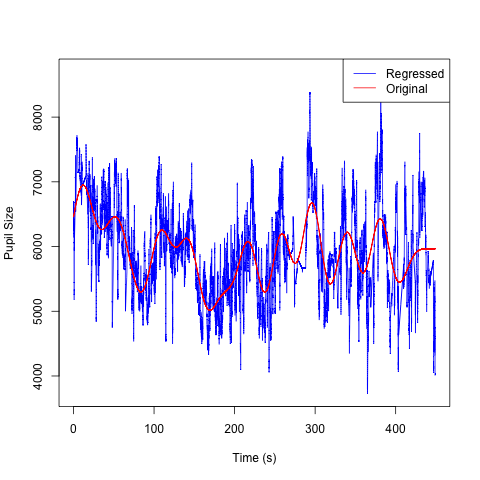

In [35]:
%%R
# Plot to compare how the data looks
time <- eye_preproc$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000

# plot pupil_raw and pupil_raw_orig
plot(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size")
lines(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)

In [60]:
%%R
# (9) Epoch the data and compute baseline pupil size for trials
eye_preproc <- eyeris::epoch(eye_preproc, events = "flag_TrialStart*", calc_baseline = TRUE, apply_baseline = FALSE, baseline_events = "flag_TrialStart*", baseline_period = c(-0.5, 0), limits = c(0, 4))
# eye_preproc <- eyeris::epoch(eye_preproc, events = "flag_Response*", calc_baseline = FALSE, apply_baseline = FALSE, limits = c(-1.5, 1.5))
# eye_preproc$epoch_flagTrialstart$trial <- as.numeric(gsub(".*_Trial(\\d+)_.*", "\\1", eye_preproc$epoch_flagTrialstart$matched_event))
# eye_preproc$epoch_flagResponse$trial <- as.numeric(gsub(".*_Trial(\\d+)_.*", "\\1", eye_preproc$epoch_flagResponse$matched_event))

In [63]:
%%R
names(eye_preproc)

[1] "file"                                                                                        
[2] "timeseries"                                                                                  
[3] "events"                                                                                      
[4] "blinks"                                                                                      
[5] "info"                                                                                        
[6] "latest"                                                                                      
[7] "params"                                                                                      
[8] "baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_z_sub_bl_corr_epoch_flagTrialstart"
[9] "epoch_flagTrialstart"                                                                        


In [65]:
%%R
baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_z_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch


In [67]:
%%R
# trial_num is from 1 to len(baseline)
trial_num <- 1:length(baseline)

In [69]:
%%R
trial_num + 64

 [1]  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
[20]  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
[39] 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
[58] 122 123 124 125 126 127 128


In [43]:
%%R
eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch

 [1] 6457.515 6754.512 6939.075 6890.224 6677.682 6423.492 6276.245 6336.985
 [9] 6425.871 6446.165 6162.687 5629.643 5375.322 5321.506 5614.762 5991.471
[17] 6223.370 6222.662 6037.090 6000.216 6070.047 6101.504 5888.688 5296.957
[25] 5023.940 5042.797 5170.810 5293.686 5356.662 5550.171 5896.499 6070.559
[33] 5977.790 5489.301 5295.647 5466.032 5781.990 6119.211 6107.576 5838.549
[41] 5810.879 6293.825 6662.302 6317.398 5693.301 5422.683 5560.604 5904.399
[49] 6204.454 6164.038 5950.943 5673.341 5597.726 5753.500 6077.946 6357.274
[57] 6317.561 5960.257 5624.085 5461.014 5687.797 5881.786 5943.729 5964.398


In [39]:
%%R
str(eye_preproc$epoch_flagTrialstart)

tibble [12,800 × 21] (S3: tbl_df/tbl/data.frame)
 $ bin                                             : num [1:12800] 7 8 9 10 11 12 13 14 15 16 ...
 $ eye_x                                           : num [1:12800] 964 964 963 964 964 ...
 $ eye_y                                           : num [1:12800] 506 504 508 517 515 ...
 $ pupil_raw                                       : num [1:12800] 6694 6700 6703 6591 6591 ...
 $ pupil_raw_deblink                               : num [1:12800] 6694 6700 6703 6591 6591 ...
 $ pupil_raw_deblink_detransient                   : num [1:12800] 6695 6700 6705 6591 6591 ...
 $ pupil_raw_deblink_detransient_interpolate       : num [1:12800] 6696 6700 6684 6591 6591 ...
 $ pupil_raw_deblink_detransient_interpolate_lpfilt: num [1:12800] 6462 6464 6465 6466 6468 ...
 $ time_orig                                       : int [1:12800] 627975 627995 628015 628035 628055 628075 628095 628115 628135 628155 ...
 $ timebin                                        

In [23]:
%%R
eye_preproc$epoch_flagTrialstart$baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch[eye_preproc$epoch_flagTrialstart$trial]
eye_preproc$epoch_flagResponse$baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch[eye_preproc$epoch_flagResponse$trial]
eye_preproc$epoch_flagTrialstart$ps_preprocessed <- (eye_preproc$epoch_flagTrialstart$pupil_raw_deblink_detransient_interpolate_lpfilt - eye_preproc$epoch_flagTrialstart$baseline) / (eye_preproc$epoch_flagTrialstart$baseline + mean_pupil_size)
eye_preproc$epoch_flagResponse$ps_preprocessed <- (eye_preproc$epoch_flagResponse$pupil_raw_deblink_detransient_interpolate_lpfilt - eye_preproc$epoch_flagResponse$baseline) / (eye_preproc$epoch_flagResponse$baseline + mean_pupil_size)

In [24]:
%%R
eye_preproc$epoch_flagTrialstart$sub <- subject_num
eye_preproc$epoch_flagResponse$sub <- subject_num
eye_preproc$epoch_flagTrialstart$trial <- eye_preproc$epoch_flagTrialstart$trial + (run_num-1) * 64
eye_preproc$epoch_flagResponse$trial <- eye_preproc$epoch_flagResponse$trial + (run_num-1) * 64


# (10) Select the relevant columns to save
output_data <- eye_preproc$epoch_flagTrialstart %>%
    select(sub, timebin, trial, ps_preprocessed, blink, outofbounds)

output_data2 <- eye_preproc$epoch_flagResponse %>%
    select(sub, timebin, trial, ps_preprocessed, blink, outofbounds)

In [32]:
%%R
data_summary <- output_data %>%
  group_by(trial) %>%
  summarise(mean_blink = mean(blink, na.rm = TRUE)) %>%
  filter(mean_blink <= 0.5) %>%
  select(trial)

filtered_data <- output_data %>%
  semi_join(data_summary, by = "trial")

In [36]:
%%R
filtered_summary <- filtered_data %>%
  group_by(timebin) %>%
  summarise(mean_ps = mean(ps_preprocessed, na.rm = TRUE))